# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 14/06/2024</small></i></div>

Este notebook tiene como objetivo la definición de la última fase del modelo de difusión, es decir, el entrenamiento un modelo DDPM.

Para ello, este notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Carga del dataset](#-1.-Carga-del-dataset)

- [2. Modelo](#-2.-Modelo)

  - [2.1. Entrenamiento](#21-entrenamiento)
  - [2.2 Evaluación del modelo](#22-evaluación-del-modelo)
  - [2.3 Resultados y guardado del modelo](#23-resultados-y-guardado-del-modelo)

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()``. Para implementar el training se ha usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido la funcionalidad extra que permiten guardar cada 100 epochs los pesos del modelo en un fichero con extensión `.weights.h5`. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo o para comparar la generación de muestras a lo largo del entrenamiento, entre otras cosas. Además, también se añade la posibilidad de, cada N epochs (siendo N un número determinado por el usuario), hacer una muestra donde se plotea el proceso de sampling desde $t = T$ hasta $t = 0$ y siempre partiendo desde el mismo ruido, todo ello, para ver como evoluciona el entrenamiento a lo largo de los epochs.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Este proceso de guardado se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde mas o menos se quedó sin problemas.
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
>
> Para más información: `src/model/model_callbacks`.
</small></i>

# 0. Imports

Una vez introducido el objetivo de este notebook, se importan las librerías necesarias para el desarrollo del apartado.

---

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-07-10 23:25:42.544724: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 23:25:42.576696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 23:25:43.867243: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 23:25:43.870961: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Carga del dataset

En este apartado, se cargará el dataset que se usará para entrenar el modelo de difusión. En este caso, se usará el tf.data.Dataset creado en los notebooks anteriores. Pero con la ligera diferencia de que esta vez dividiremos dicho dataset en train y test para posteriormente al entreno del modelo evaluarlo usando el conjunto de test para garantizar el buen entrenamiento del modelo de difusión.

---

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-07-10 23:25:44.603922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-07-10 23:25:45.251007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Train size: 3872 sprites
- Test size: 192 sprites


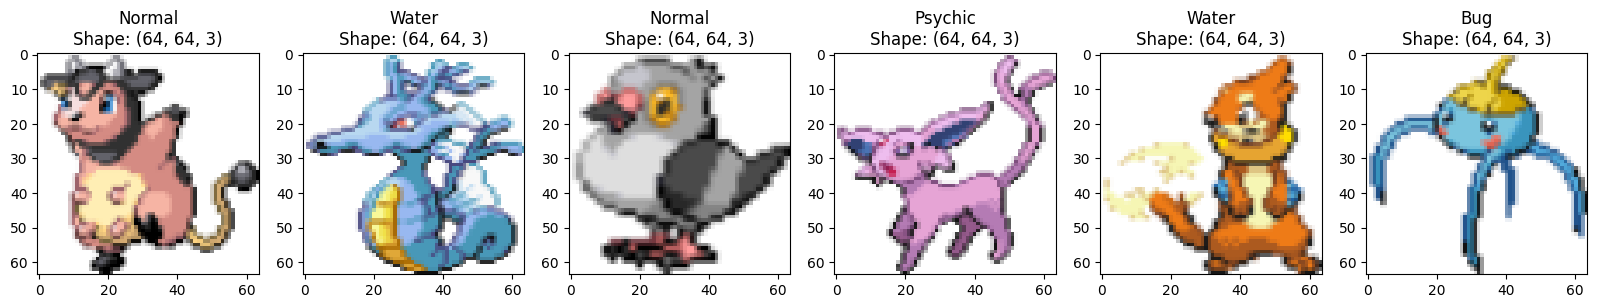

2024-07-10 23:25:46.336174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


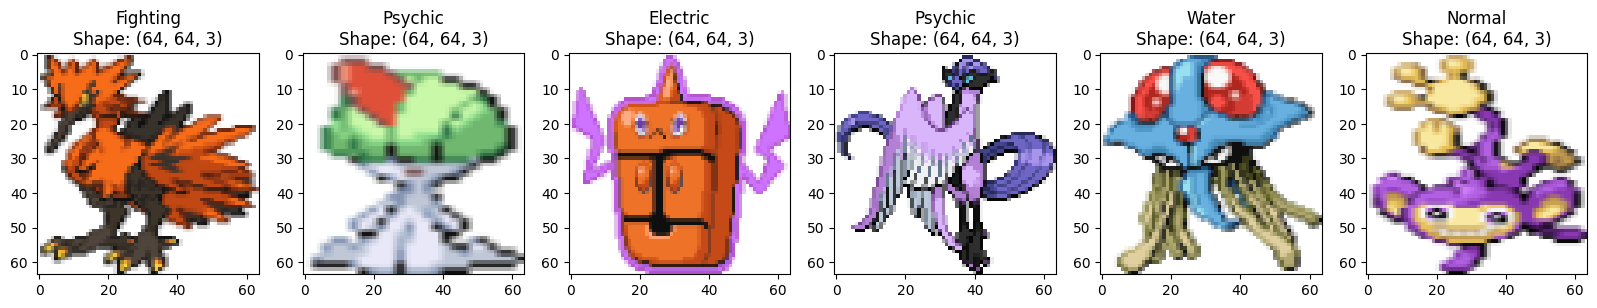

2024-07-10 23:25:46.602423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# train test split
# =====================================================================
train_poke_dataset, test_poke_dataset = tf.keras.utils.split_dataset(
    poke_dataset, left_size=0.95, shuffle=True
)

# Length of the datasets
print(f"- Train size: {len(train_poke_dataset) * BATCH_SIZE} sprites")
print(f"- Test size: {len(test_poke_dataset) * BATCH_SIZE} sprites")

# Plot
visualize.plot_images_batch(train_poke_dataset, 6)
visualize.plot_images_batch(test_poke_dataset, 6)

# 2. Modelo

Definimos el modelo usando la arquitectura **U-Net** y añadiendo las funcionalidades de un modelo de difusión con la clase `DiffusionModel()`.

---

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Entrenamiento

Entrenamos el modelo con los `EPOCHS` definido como hiperparámetro en el `config.ini` y añadimos la funcionalidad de guardado y muestreo de imágenes durante el entrenamiento a través del callback `DiffusionCallback`.

Epoch 1/400


I0000 00:00:1720653960.056945  131850 service.cc:145] XLA service 0x71344c018960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720653960.056965  131850 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-10 23:26:00.449559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1720653960.930335  131850 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
W0000 00:00:1720653960.959502  131850 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1
2024-07-10 23:26:01.884

  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:22:36 41s/step - mae: 1.1599 - loss: 2.1149

I0000 00:00:1720653989.634190  131850 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_59', 80 bytes spill stores, 80 bytes spill loads

I0000 00:00:1720653989.654753  131850 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - mae: 0.7100 - loss: 0.8621

I0000 00:00:1720654004.854987  132834 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 172 bytes spill stores, 172 bytes spill loads



121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 145ms/step - mae: 0.7086 - loss: 0.8595 - val_loss: 0.2642 - val_mae: 0.3729
Epoch 2/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.3458 - loss: 0.2301 - val_loss: 0.1817 - val_mae: 0.2998
Epoch 3/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.2929 - loss: 0.1733 - val_loss: 0.1576 - val_mae: 0.2734
Epoch 4/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.2673 - loss: 0.1500 - val_loss: 0.1505 - val_mae: 0.2614
Epoch 5/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - mae: 0.2487 - loss: 0.1351 - val_loss: 0.1222 - val_mae: 0.2363
Epoch 6/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.2408 - loss: 0.1281 - val_loss: 0.1187 - val_mae: 0.2302
Epoch 7/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.2311 - loss: 0.1207 - val_loss: 0.1375 - val_mae: 0.2421
Epoch 8/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.2244 - loss: 0.1152 - val_loss: 0.1020 - val_mae: 0.2112
Epoch 9/400
121/121 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.23it/s]


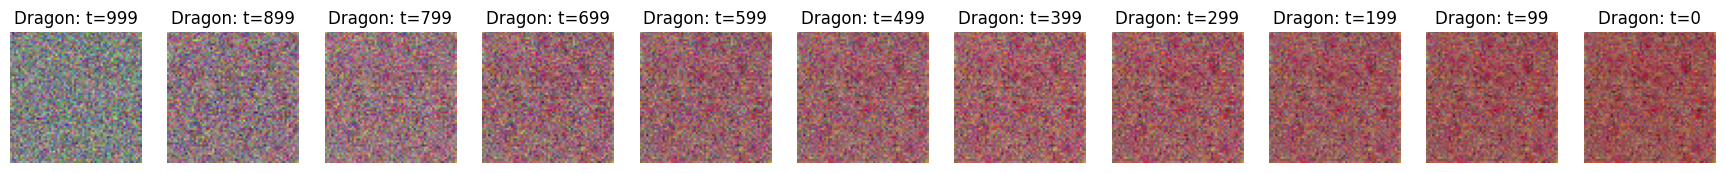

121/121 ━━━━━━━━━━━━━━━━━━━━ 103s 858ms/step - mae: 0.1821 - loss: 0.0889 - val_loss: 0.0747 - val_mae: 0.1675
Epoch 26/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - mae: 0.1723 - loss: 0.0804 - val_loss: 0.0903 - val_mae: 0.1828
Epoch 27/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1764 - loss: 0.0842 - val_loss: 0.0948 - val_mae: 0.1851
Epoch 28/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1737 - loss: 0.0826 - val_loss: 0.0790 - val_mae: 0.1691
Epoch 29/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1718 - loss: 0.0814 - val_loss: 0.0839 - val_mae: 0.1730
Epoch 30/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1671 - loss: 0.0765 - val_loss: 0.0798 - val_mae: 0.1743
Epoch 31/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1673 - loss: 0.0772 - val_loss: 0.0726 - val_mae: 0.1644
Epoch 32/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1674 - loss: 0.0782 - val_loss: 0.0783 - val_mae: 0.1702
Epoch 33/400
121/121 ━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.25it/s]


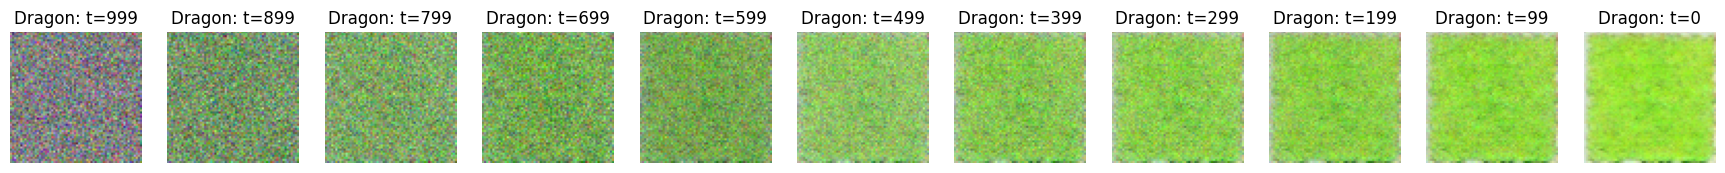

121/121 ━━━━━━━━━━━━━━━━━━━━ 103s 858ms/step - mae: 0.1596 - loss: 0.0748 - val_loss: 0.0707 - val_mae: 0.1554
Epoch 51/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1552 - loss: 0.0703 - val_loss: 0.0686 - val_mae: 0.1552
Epoch 52/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1615 - loss: 0.0757 - val_loss: 0.0686 - val_mae: 0.1512
Epoch 53/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1624 - loss: 0.0746 - val_loss: 0.0559 - val_mae: 0.1414
Epoch 54/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1546 - loss: 0.0697 - val_loss: 0.0737 - val_mae: 0.1588
Epoch 55/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1557 - loss: 0.0711 - val_loss: 0.0775 - val_mae: 0.1625
Epoch 56/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1576 - loss: 0.0716 - val_loss: 0.0655 - val_mae: 0.1490
Epoch 57/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1555 - loss: 0.0720 - val_loss: 0.0666 - val_mae: 0.1525
Epoch 58/400
121/121 ━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.25it/s]


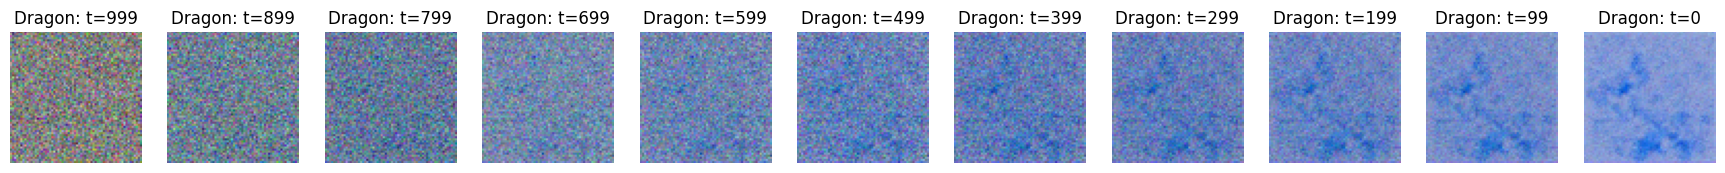

121/121 ━━━━━━━━━━━━━━━━━━━━ 103s 857ms/step - mae: 0.1504 - loss: 0.0677 - val_loss: 0.0669 - val_mae: 0.1507
Epoch 76/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - mae: 0.1463 - loss: 0.0649 - val_loss: 0.0656 - val_mae: 0.1479
Epoch 77/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1531 - loss: 0.0703 - val_loss: 0.0684 - val_mae: 0.1498
Epoch 78/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1466 - loss: 0.0650 - val_loss: 0.0659 - val_mae: 0.1494
Epoch 79/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1471 - loss: 0.0651 - val_loss: 0.0648 - val_mae: 0.1502
Epoch 80/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1510 - loss: 0.0692 - val_loss: 0.0739 - val_mae: 0.1567
Epoch 81/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1505 - loss: 0.0683 - val_loss: 0.0816 - val_mae: 0.1629
Epoch 82/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1468 - loss: 0.0653 - val_loss: 0.0611 - val_mae: 0.1423
Epoch 83/400
121/121 ━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.31it/s]


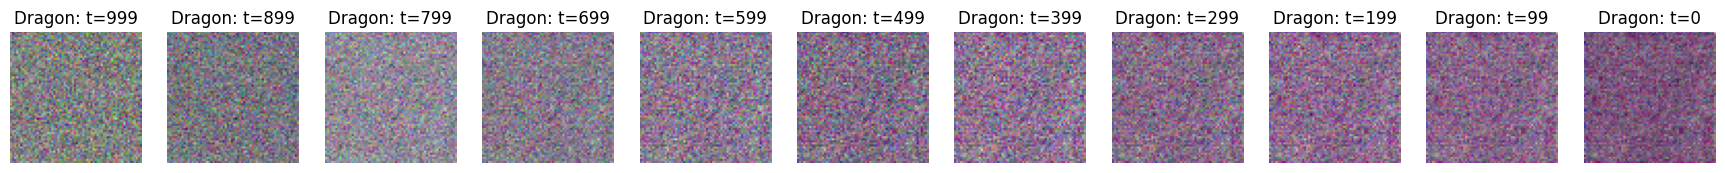

121/121 ━━━━━━━━━━━━━━━━━━━━ 103s 856ms/step - mae: 0.1465 - loss: 0.0646 - val_loss: 0.0656 - val_mae: 0.1496
Epoch 101/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - mae: 0.1449 - loss: 0.0640 - val_loss: 0.0702 - val_mae: 0.1504
Epoch 102/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1432 - loss: 0.0639 - val_loss: 0.0586 - val_mae: 0.1387
Epoch 103/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1423 - loss: 0.0617 - val_loss: 0.0511 - val_mae: 0.1297
Epoch 104/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1419 - loss: 0.0621 - val_loss: 0.0738 - val_mae: 0.1518
Epoch 105/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - mae: 0.1431 - loss: 0.0628 - val_loss: 0.0599 - val_mae: 0.1373
Epoch 106/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - mae: 0.1416 - loss: 0.0617 - val_loss: 0.0678 - val_mae: 0.1481
Epoch 107/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1386 - loss: 0.0596 - val_loss: 0.0704 - val_mae: 0.1532
Epoch 108/400
121/121

Sampling sprite...: 100%|██████████| 999/999 [01:27<00:00, 11.39it/s]


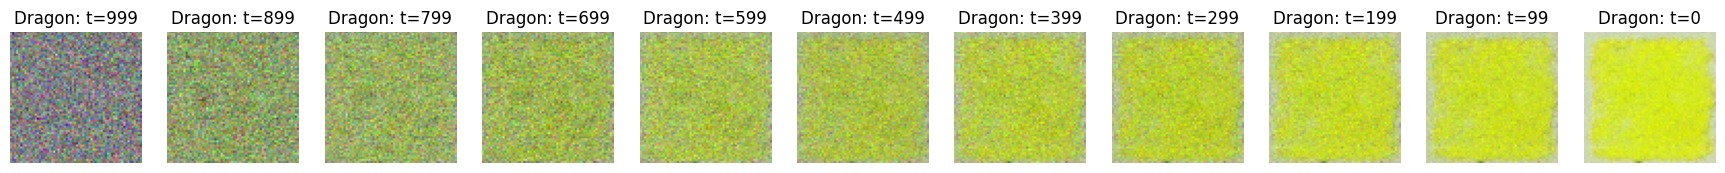

121/121 ━━━━━━━━━━━━━━━━━━━━ 102s 848ms/step - mae: 0.1415 - loss: 0.0629 - val_loss: 0.0640 - val_mae: 0.1476
Epoch 126/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - mae: 0.1413 - loss: 0.0619 - val_loss: 0.0733 - val_mae: 0.1573
Epoch 127/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1346 - loss: 0.0569 - val_loss: 0.0610 - val_mae: 0.1415
Epoch 128/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1400 - loss: 0.0613 - val_loss: 0.0582 - val_mae: 0.1410
Epoch 129/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1394 - loss: 0.0606 - val_loss: 0.0643 - val_mae: 0.1420
Epoch 130/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1323 - loss: 0.0546 - val_loss: 0.0698 - val_mae: 0.1556
Epoch 131/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1394 - loss: 0.0609 - val_loss: 0.0647 - val_mae: 0.1473
Epoch 132/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - mae: 0.1401 - loss: 0.0606 - val_loss: 0.0567 - val_mae: 0.1374
Epoch 133/400
121/121

Sampling sprite...: 100%|██████████| 999/999 [01:27<00:00, 11.39it/s]


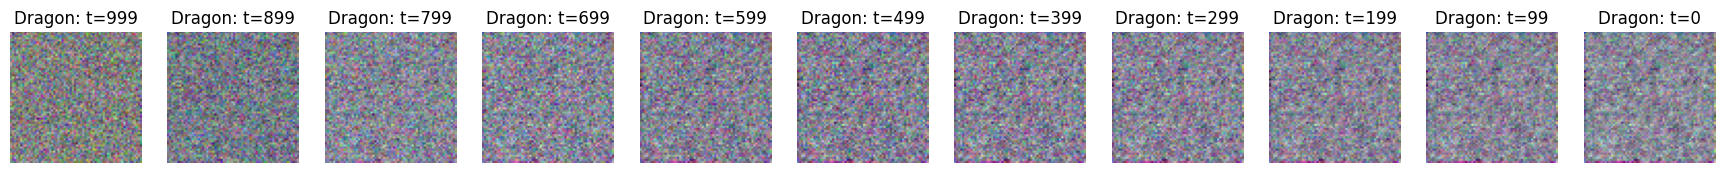

121/121 ━━━━━━━━━━━━━━━━━━━━ 102s 848ms/step - mae: 0.1384 - loss: 0.0610 - val_loss: 0.0609 - val_mae: 0.1423
Epoch 151/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - mae: 0.1357 - loss: 0.0581 - val_loss: 0.0590 - val_mae: 0.1378
Epoch 152/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1378 - loss: 0.0602 - val_loss: 0.0576 - val_mae: 0.1366
Epoch 153/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1356 - loss: 0.0583 - val_loss: 0.0620 - val_mae: 0.1395
Epoch 154/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - mae: 0.1370 - loss: 0.0596 - val_loss: 0.0548 - val_mae: 0.1314
Epoch 155/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - mae: 0.1381 - loss: 0.0604 - val_loss: 0.0577 - val_mae: 0.1377
Epoch 156/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - mae: 0.1332 - loss: 0.0565 - val_loss: 0.0579 - val_mae: 0.1363
Epoch 157/400
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - mae: 0.1343 - loss: 0.0577 - val_loss: 0.0606 - val_mae: 0.1370
Epoch 158/400
121/121

In [7]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 25, "Dragon")
history = model.fit(
    train_poke_dataset,
    epochs=400,
    validation_data=test_poke_dataset,
    callbacks=[diff_callback],
)

## 2.2. Evaluación del modelo

Una vez entrenado el modelo, lo evaluamos gracias al conjunto de testeo que definimos anteriormente. Para evaluar el entrenamiento del modelo se mostrarán la evolución de los valores de la función de perdida y las métricas a lo largo del entrenamiento. Todo ello, para garantizar el correcto entrenamiento del modelo de difusión, evitando su overfitting principalmente.

Y tal y como podemos observar el modelo no sufre de overfitting y ambas funciones tienen a minimizar el error cometido correctamente, por lo que podemos garantizar que el entrenamiento se ha realizado con éxito.

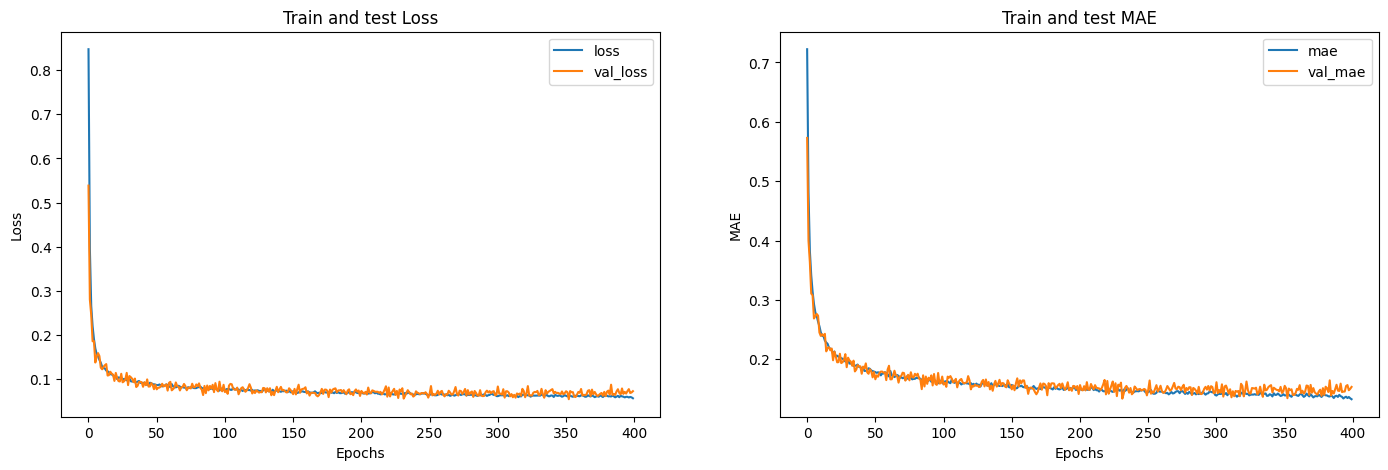

In [ ]:
visualize.plot_history(history)

## 2.3. Resultados y guardado del modelo

Finalmente, una vez comprobado el correcto entrenamiento del modelo, procedemos a guardarlo para futuras síntesis de imágenes sin necesidad de estar entrenando de nuevo el modelo. Además, aprovechamos para mostrar la generación de imágenes tras el entrenamiento del modelo.

In [ ]:
# Save and load the model
# =====================================================================
save_path = f"{MODELS_PATH}/diffusion_{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}_epochs{EPOCHS}.weights.h5"
save_path = f"{MODELS_PATH}/beta3_final_less_neurons_diffusion_{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}_epochs{400}.weights.h5"
model.save_weights(save_path)

model_loaded = DiffusionModel.load_model(
    save_path,
    u_net,
    IMG_SIZE,
    NUM_CLASSES,
    TIMESTEPS,
    BETA_START,
    BETA_END,
    S,
    SCHEDULER,
)

/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 366 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Sample some sprites
# =====================================================================
model_loaded.plot_samples(6)
model_loaded.plot_samples(6)
model_loaded.plot_samples(6)
model_loaded.plot_samples(6, "Fire")
model_loaded.plot_samples(6, "Water")
model_loaded.plot_samples(6, "Grass")

[BACK TO TOP](#top)